In [508]:
#import necessary libraries 
import pandas as pd # data processing
import numpy as np #lienar algebra
import seaborn as sns #plots/viz
import matplotlib.pyplot as plt #plots/viz
%matplotlib inline 

import os #to locate current working directory, file paths to load in datasets
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
cwd = os.getcwd()
print(cwd)

In [470]:
def files_to_dataframe(rel_path):
    
    '''Takes files containing 2019 Monthly Sales Data, creates dataframe for initial file, 
    unions each subsequent file. Saves final output to .csv for use'''
    
    file_list = [file for file in os.listdir(rel_path) if 'Sales' in file] 
    
    sales_df = pd.DataFrame()    
    
    for file in file_list:
        x = pd.read_csv(rel_path + file)
        sales_df = pd.concat([sales_df, x]) 
    sales_df.to_csv("../Portfolio Datasets/all_sales_data_2019.csv", index=False)

In [471]:
files_to_dataframe('../Portfolio Datasets/')
sales_df = pd.read_csv('..\Portfolio Datasets/all_sales_data_2019.csv')

In [472]:
def preprocessing(data): # provides a quick glimpse at the dataset for preprocessing 
    print("ROWS: {}".format(data.shape[0]))
    print("\nCOLUMNS: {}".format(data.shape[1]))
    print("\nNULL VALUES:\n\n{}".format(data.isnull().sum()))
    print("\nNULL PERCENTAGES:\n\n{}\n".format(data.isnull().sum() / len(data) * 100))
    print("\nDUPLICATES:\n{}".format(data.duplicated().sum()))
    print("\n %r:" %(data.info()))

In [473]:
preprocessing(sales_df)

ROWS: 186850

COLUMNS: 6

NULL VALUES:

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
dtype: int64

NULL PERCENTAGES:

Order ID            0.291678
Product             0.291678
Quantity Ordered    0.291678
Price Each          0.291678
Order Date          0.291678
Purchase Address    0.291678
dtype: float64


DUPLICATES:
1162
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB

 None:


In [474]:
sales_df.columns = sales_df.columns.str.replace(" ", "_") 
#changing column names to have underscore for easier calling

In [475]:
sales_df = sales_df.dropna(how='all') #dropping all NaN values 

In [476]:
sales_df.Order_Date.value_counts() 
sales_df[sales_df['Order_Date'].str[0:2] == "Or"][:5] #there are dozens of rows that repeat column titels
#going to remove these from the dataset through exclusion (below cell)

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address
519,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1149,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1155,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
2878,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
2893,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


In [477]:
sales_df = sales_df[sales_df['Order_Date'].str[0:2] != "Or"] #excluding Order_Dates with 'Or" as first 2 letters

In [478]:
#converting series to appropriate datatypes, along with additional feature engineering 
sales_df['Quantity_Ordered']= sales_df['Quantity_Ordered'].astype('int64')
sales_df['Price_Each'] =  sales_df['Price_Each'].astype('float')
sales_df['Order_Date'] = pd.to_datetime(sales_df['Order_Date']) 
sales_df['Order_Cost'] = sales_df['Price_Each'] * sales_df['Quantity_Ordered']

In [479]:
sales_df['Order_Month'] = sales_df['Order_Date'].dt.month
sales_df['Order_Year_Month'] = sales_df['Order_Date'].dt.to_period('M')
sales_df['Order_Month_Name'] = sales_df['Order_Date'].dt.month_name()
sales_df['Order_DOW'] = sales_df['Order_Date'].dt.day_name()
sales_df['Order_Year']  = sales_df['Order_Date'].dt.year
sales_df['Order_Hour'] = sales_df['Order_Date'].dt.hour

In [480]:
sales_df['City'] = sales_df['Purchase_Address'].apply(lambda x: x.split(',')[1])
sales_df['State'] = sales_df['Purchase_Address'].apply(lambda x: x.split(',')[2].split(" ")[1])

In [481]:
sales_df[sales_df['Order_Cost'] < 0] #checking to see if there are any negative costs (returns, cancelled orders, etc.)

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Order_Cost,Order_Month,Order_Year_Month,Order_Month_Name,Order_DOW,Order_Year,Order_Hour,City,State


Question 1

Text(0.5, 1.0, 'With 185916 total orders, 2019 was the best year for sales. Total revenue: $34483365.68.')

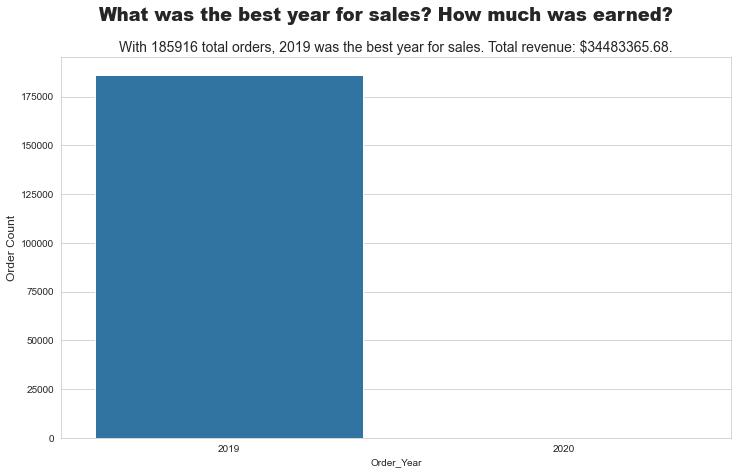

In [482]:
plt.figure(figsize=(12, 7))

sns.countplot(data=sales_df, x='Order_Year')

sales_df.Order_Year.value_counts() #while sales in 2020 low, it's important to note they aren't nonexistent

yr_sales = sales_df.Order_Year.value_counts().values[0]
yr_rev = sales_df.groupby('Order_Year')['Order_Cost'].sum().sort_values(ascending=False).values[0]

                                                                                                # plt.xlabel("Year", fontsize=12)
plt.ylabel('Order Count', fontsize=12)
plt.suptitle("What was the best year for sales? How much was earned?", fontsize=18, fontweight='heavy')
plt.title(f"With {yr_sales} total orders, 2019 was the best year for sales. Total revenue: ${yr_rev}.",\
         fontsize=14)

Question 2

Text(0, 5100000, 'December was the best month for sales with $4613443.34 in total sales.')

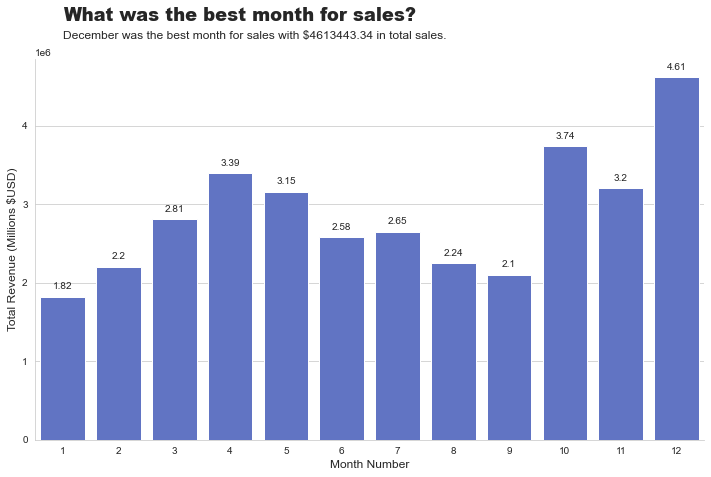

In [483]:
fig, ax = plt.subplots(figsize=(12, 7))

month_sales = sales_df.groupby(['Order_Month'])['Order_Cost'].sum().to_frame('Total_Revenue').reset_index()

sns.barplot(data=month_sales, x='Order_Month', y='Total_Revenue', color='#506AD4')

def annotate_bars(axs): 
    for p in ax.patches: 
        x = p.get_x() + p.get_width() -0.4
        y = p.get_y() + p.get_height() + 100000
        value = '{:.0f}'.format(p.get_height())
        value = np.round(int(value) / 1000000, 2)
        ax.text(x, y, value, ha='center')

annotate_bars(ax)

sns.despine(right=True, top=True)
plt.xlabel('Month Number', fontsize=12)
plt.ylabel('Total Revenue (Millions $USD)', fontsize=12)

ax.text(0, 5330000, "What was the best month for sales?", {'fontsize':18, 'fontweight':'heavy'})
ax.text(0, 5100000, f"December was the best month for sales with ${month_sales['Total_Revenue'].max()} in total sales.", fontsize=12)

Question 3

Text(12, 16583.0, 'Average')

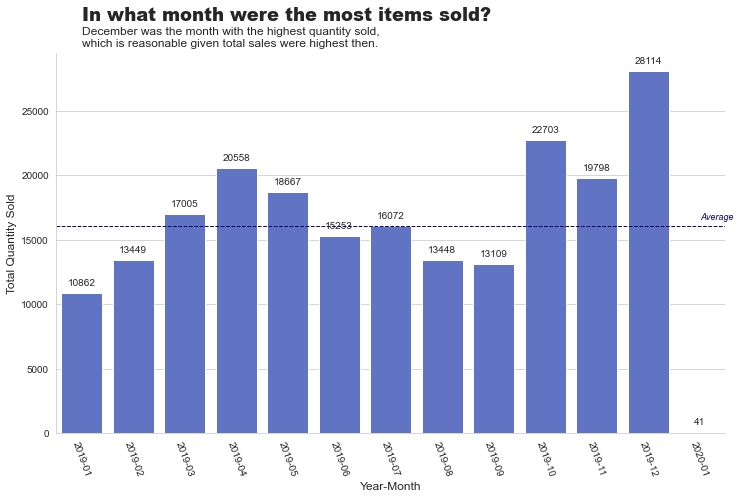

In [484]:
fig, ax = plt.subplots(figsize=(12, 7))

ym_sales = sales_df.groupby(['Order_Year_Month'])['Quantity_Ordered'].sum().to_frame('Total Orders')\
    .sort_values('Order_Year_Month', ascending=True)

sns.barplot(data=ym_sales, x=ym_sales.index, y='Total Orders', color='#506AD4')

def annotate_bars(axs): 
    for p in ax.patches: 
        x = p.get_x() + p.get_width() -0.4
        y = p.get_y() + p.get_height() + 600
        value = '{:.0f}'.format(p.get_height())
        ax.text(x, y, value, ha='center')

annotate_bars(ax)
plt.xticks(rotation=290)
plt.ylabel('Total Quantity Sold', fontsize=12)
plt.xlabel('Year-Month', fontsize=12)
sns.despine(top=True, right=True)
ax.text(0, 32000, "In what month were the most items sold?", {'fontsize':18, 'fontweight':'heavy'})
ax.text(0, 30000, "December was the month with the highest quantity sold,\
        \nwhich is reasonable given total sales were highest then.", 
       fontsize=12)

plt.axhline(ym_sales['Total Orders'].mean(), color='#110066', linestyle='--', linewidth=1)
ax.text(12, ym_sales['Total Orders'].mean() + 500, 'Average', fontsize=9, fontstyle='italic', color='#110066')

Question 4

In [485]:
#M = Midwest
#S = South
#N = Northeast
#W = West 

regional_dict = {
        'AK': 'West', 'AL': 'South', 'AR': 'South', 'AZ': 'West', 'CA': 'West',
        'CO': 'West', 'CT': 'Northeast', 'DE': 'Northeast', 'FL': 'South', 'GA': 'South',
        'HI': 'West', 'IA': 'Midwest', 'ID': 'West', 'IL': 'Midwest', 'IN': 'Midwest',
        'KS': 'Midwest', 'KY': 'South', 'LA': 'South', 'MA': 'Northeast', 'MD': 'Northeast',
        'ME': 'Northeast', 'MI': 'West', 'MN': 'Midwest', 'MO': 'Midwest', 'MS': 'South',
        'MT': 'West', 'NC': 'South', 'ND': 'Midwest', 'NE': 'West', 'NH': 'Northeast',
        'NJ': 'Northeast', 'NM': 'West', 'NV': 'West', 'NY': 'Northeast', 'OH': 'Midwest', 'OK': 'South',
        'OR': 'West', 'PA': 'Northeast', 'RI': 'Northeast', 'SC': 'South', 'SD': 'Midwest', 'TN': 'South',
        'TX': 'South', 'UT': 'West', 'VA': 'South', 'VT': 'Northeast', 'WA': 'West', 'WI': 'Midwest',
        'WV': 'South', 'WY': 'West'
}

In [486]:
len(regional_dict) #checking to see if I listed all 50 states
sales_df['Region'] = sales_df['State'].map(regional_dict)

In [487]:
regional_rev = sales_df.groupby(['Order_Year_Month', 'Region'])['Order_Cost'].sum().to_frame('Total_Revenue').reset_index()

In [488]:
sales_df.groupby(['Region', 'City'])['Order_Cost'].sum().to_frame('Total Revenue').sort_values('Total Revenue', ascending=False).reset_index()

,Region,City,Total Revenue
0,West,San Francisco,8262203.91
1,West,Los Angeles,5452570.80
2,Northeast,New York City,4664317.43
3,Northeast,Boston,3661642.01
4,South,Atlanta,2795498.58
5,South,Dallas,2767975.40
6,West,Seattle,2747755.48
7,West,Portland,1870732.34
8,South,Austin,1819581.75
9,Northeast,Portland,449758.27


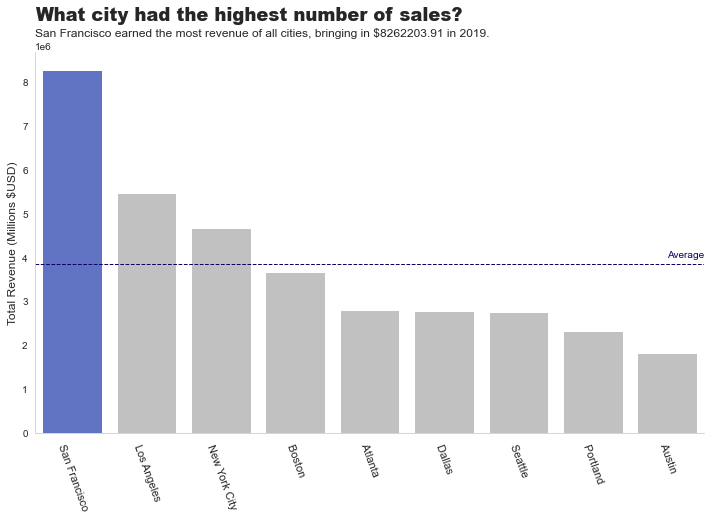

In [431]:
fig, ax = plt.subplots(figsize=(12, 7))

sns.set_style('whitegrid')
city = sales_df.groupby(['City'])['Order_Cost'].sum().to_frame('Total Revenue')\
    .sort_values('Total Revenue', ascending=False).reset_index()

def highlight_bars(df, series, max_color, min_color): 
    pal = [] 
    max_val = df[series].max()
    
    for r in df[series]: 
        if r == max_val: 
            pal.append(max_color)
        else:
            pal.append(min_color)
    return pal
        
sns.barplot(data=city, x='City', y='Total Revenue', 
            palette=highlight_bars(city, 'Total Revenue', '#506AD4', '#C1C1C1'))

ax.text(-0.5, 9400000, "What city had the highest number of sales?", {'fontsize': 18, 'fontweight':'heavy'})
ax.text(-0.5, 9050000, f"San Francisco earned the most revenue of all cities, bringing in ${city['Total Revenue'].max()} in 2019.", fontsize=12)

plt.ylabel('Total Revenue (Millions $USD)', fontsize=12)
plt.xlabel('')
plt.xticks(fontsize=11, rotation=290)

plt.axhline(city['Total Revenue'].mean(), linestyle='--', linewidth=1, color='#110066')
ax.text(8, 4000000, "Average", color='#110066')

ax.grid(False)
sns.despine()

Text(-0.5, 2700000, 'Driven by Los Angeles and San Francisco, the West generated the most revenue.')

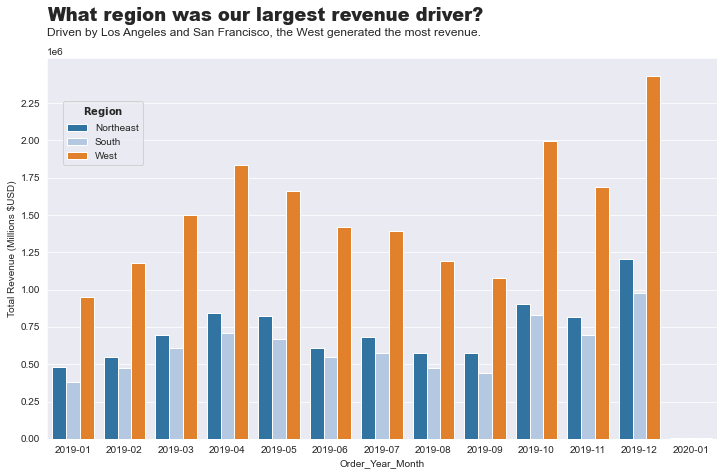

In [492]:
fig, ax = plt.subplots(figsize=(12, 7))

sns.set_style('darkgrid')
sns.barplot(data=regional_rev, x='Order_Year_Month', y='Total_Revenue', hue='Region', palette='tab20')

leg = plt.legend(title=r'$\bf{Region}$', 
                 title_fontsize=10, 
                bbox_to_anchor=(0.15, 0.9), 
                fancybox=True)

plt.yticks(np.arange(0, 2500000, step=250000))

plt.ylabel('Total Revenue (Millions $USD)')
ax.text(-0.5, 2800000, "What region was our largest revenue driver? ", {'fontsize': 18, 'fontweight':'heavy'})
ax.text(-0.5, 2700000, "Driven by Los Angeles and San Francisco, the West generated the most revenue.", fontsize=12)


Question 4

C:\Users\ANAJON~1\AppData\Local\Temp/ipykernel_11280/3949680328.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(labels, fontsize=13)


Text(0.5, 2.25, 'We should show ads prior to our best selling times of day, notably in the morning or mid-afternoon')

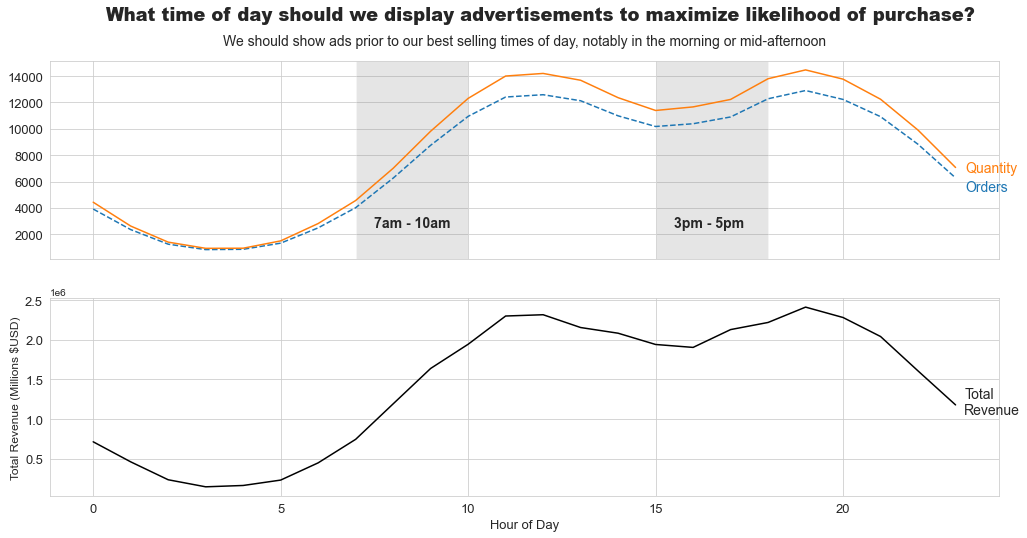

In [494]:
peak_orders = sales_df.groupby(['Order_Hour']).size().to_frame('Number of Orders')\
    .sort_values('Order_Hour', ascending=True)

peak_quant = sales_df.groupby(['Order_Hour'])['Quantity_Ordered'].sum().to_frame('Total Quantity')\
    .sort_values('Order_Hour', ascending=True)

peak_rev = sales_df.groupby(['Order_Hour'])['Order_Cost'].sum().to_frame('Total Revenue')\
    .sort_values('Order_Hour', ascending=True)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(17, 8), sharex=True, sharey=False)

sns.set_style('whitegrid')

sns.lineplot(data=peak_orders, x='Order_Hour', y='Number of Orders', ax=ax[0], linestyle='--')
sns.lineplot(data=peak_quant, x='Order_Hour', y='Total Quantity', ax=ax[0])
sns.lineplot(data=peak_rev, x='Order_Hour', y='Total Revenue', ax=ax[1], color='black')

labels = [x for x in range(0, 20000, 2000)]

plt.xlabel('Hour of Day', fontsize=13)
ax[0].set_yticklabels(labels, fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax[0].set_ylabel("")
ax[1].set_ylabel("Total Revenue (Millions $USD)", fontsize=12)
ax[0].text(23.25, 6750, "Quantity", color='tab:orange', fontsize=14)
ax[0].text(23.25, 5250, "Orders", color='tab:blue', fontsize=14)
ax[1].text(23.23, 1062500, "Total\nRevenue", fontsize=14)

ax[0].axvspan(7, 10, facecolor='grey', alpha=0.2)
ax[0].axvspan(15, 18, facecolor='grey', alpha=0.2)
ax[0].text(7.5, 2550, "7am - 10am", fontsize=14, fontweight='bold')
ax[0].text(15.5, 2550, "3pm - 5pm", fontsize=14, fontweight='bold')

plt.suptitle(x=.5250, y=0.975, t="What time of day should we display advertisements to maximize likelihood of purchase?", fontweight='heavy', fontsize=18)
plt.title('We should show ads prior to our best selling times of day, notably in the morning or mid-afternoon', fontsize=14, x=0.5, y=2.25)

Question 5

In [495]:
from collections import Counter
from itertools import combinations

cnt = Counter()

pair_data = sales_df[sales_df['Order_ID'].duplicated(keep=False)]

pair_data['pairs'] = pair_data.groupby(['Order_ID'])['Product'].transform(lambda x: ', '.join(x))

pair_data = pair_data[['Order_ID', 'pairs']].drop_duplicates()
pair_data.head()

for row in pair_data['pairs']: 
    row_list = row.split(',')
    cnt.update(Counter(combinations(row_list, 2)))

print("\033[1mWhat products are often sold together?\n")
for key, value in cnt.most_common(20): 
    print(f"\033[0m{key, value}")


What products are often sold together?

(('iPhone', ' Lightning Charging Cable'), 1005)
(('Google Phone', ' USB-C Charging Cable'), 987)
(('iPhone', ' Wired Headphones'), 447)
(('Google Phone', ' Wired Headphones'), 414)
(('Vareebadd Phone', ' USB-C Charging Cable'), 361)
(('iPhone', ' Apple Airpods Headphones'), 360)
(('Google Phone', ' Bose SoundSport Headphones'), 220)
(('Vareebadd Phone', ' Wired Headphones'), 143)
((' USB-C Charging Cable', ' Wired Headphones'), 120)
(('Vareebadd Phone', ' Bose SoundSport Headphones'), 80)
((' Lightning Charging Cable', ' Wired Headphones'), 62)
(('Lightning Charging Cable', ' USB-C Charging Cable'), 55)
(('Lightning Charging Cable', ' AA Batteries (4-pack)'), 52)
((' USB-C Charging Cable', ' Bose SoundSport Headphones'), 51)
(('Lightning Charging Cable', ' Lightning Charging Cable'), 51)
(('AA Batteries (4-pack)', ' Lightning Charging Cable'), 51)
(('AAA Batteries (4-pack)', ' USB-C Charging Cable'), 50)
(('AA Batteries (4-pack)', ' AAA Batteries

C:\Users\ANAJON~1\AppData\Local\Temp/ipykernel_11280/2635922737.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_data['pairs'] = pair_data.groupby(['Order_ID'])['Product'].transform(lambda x: ', '.join(x))


In [496]:
sales_df.head(1)

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Order_Cost,Order_Month,Order_Year_Month,Order_Month_Name,Order_DOW,Order_Year,Order_Hour,City,State,Region
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.9,4,2019-04,April,Friday,2019,8,Dallas,TX,South


Question 6

In [497]:
most_sold = sales_df.groupby(['Product']).agg({'Quantity_Ordered':'sum', 'Price_Each':'mean'})\
    .rename(columns={'Quantity_Ordered':'Quantity Ordered', 'Price_Each':'Item Price'}).reset_index()

most_sold = most_sold.sort_values('Quantity Ordered', ascending=False)
most_sold[:10]

,Product,Quantity Ordered,Item Price
5,AAA Batteries (4-pack),31017,2.99
4,AA Batteries (4-pack),27635,3.84
15,USB-C Charging Cable,23975,11.95
12,Lightning Charging Cable,23217,14.95
17,Wired Headphones,20557,11.99
6,Apple Airpods Headphones,15661,150.00
7,Bose SoundSport Headphones,13457,99.99
2,27in FHD Monitor,7550,149.99
18,iPhone,6849,700.00
1,27in 4K Gaming Monitor,6244,389.99


Text(0.0, 1.0, 'What product sold the most?')

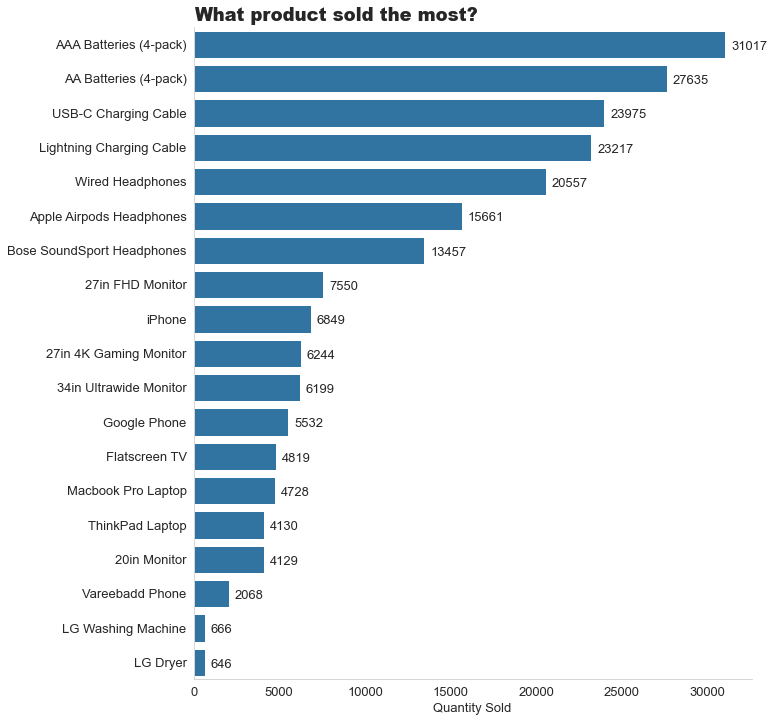

In [498]:
fig, ax = plt.subplots(figsize=(10, 12))

sns.barplot(data=most_sold, x='Quantity Ordered', y='Product', color='tab:blue')

def annotate_bars(ax):
    for p in ax.patches: 
        x = p.get_x() + p.get_width() + 350
        y = p.get_y() + p.get_height() -0.25
        value = '{:.0f}'.format(p.get_width())
        ax.text(x, y, value, fontsize=13)

annotate_bars(ax)

plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.ylabel("")
plt.xlabel('Quantity Sold', fontsize=13)

ax.grid(False)
sns.despine()

plt.title("What product sold the most?", {'fontweight':'heavy', 'fontsize':18}, loc='left')


C:\Users\ANAJON~1\AppData\Local\Temp/ipykernel_11280/3105852463.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=270, ha='right', fontsize=12)


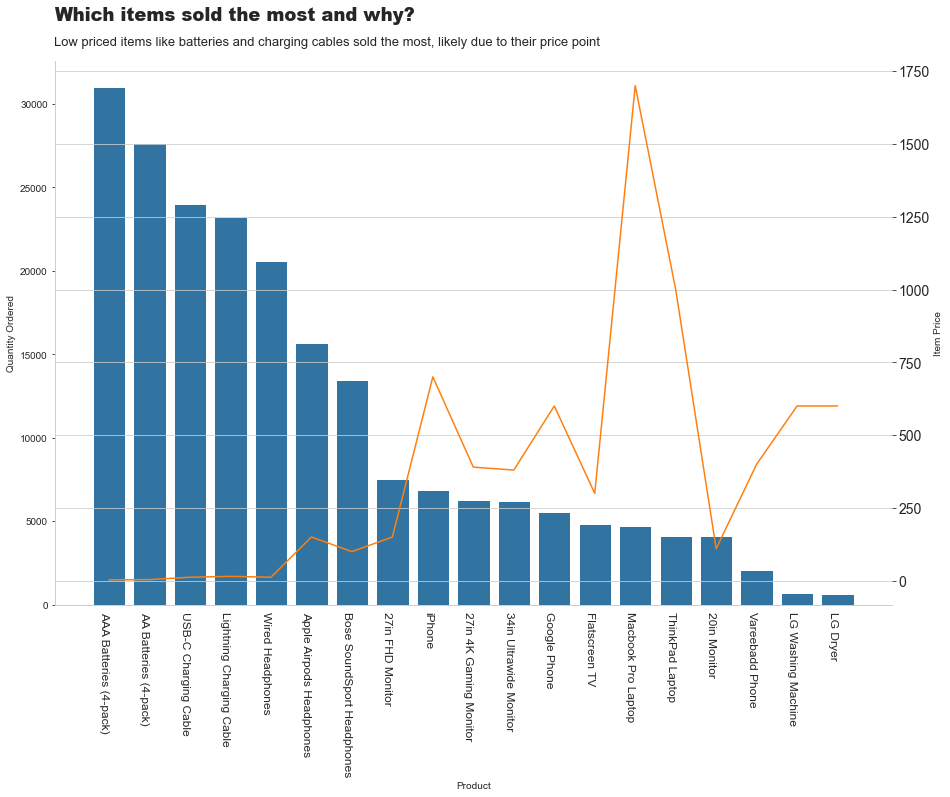

In [507]:
fig, ax = plt.subplots(figsize=(15, 10))
ax2 = ax.twinx()

sns.barplot(data=most_sold, x='Product', y='Quantity Ordered', ax=ax, color='tab:blue')
sns.lineplot(data=most_sold, x='Product', y='Item Price', ax=ax2, color='tab:orange')

x_labels=most_sold['Product']
ax.set_xticklabels(x_labels, rotation=270, ha='right', fontsize=12)

ax.text(-1.35, 35000, "Which items sold the most and why?", {'fontweight':'heavy', 'fontsize':18})
ax.text(-1.35, 33500, "Low priced items like batteries and charging cables sold the most, likely due to their price point",\
       {'fontweight':'light', 'fontsize':13})

sns.set_style('whitegrid')

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

ax.grid(False)
sns.despine()